In [116]:
%matplotlib inline

In [375]:
import networkx as nx
import numpy as np
import scipy
import pandas as pd
from scipy.sparse.linalg import eigs
from sklearn.metrics import precision_recall_fscore_support

from graph_generator.community_graph import make_random_signed_graph, connect_communities
from helpers import (
    signed_layout,
    draw_nodes,
    draw_edges,
    degree_diag,
    prepare_seed_vector,
    is_rank_one,
    sbr_by_threshold,
    flatten,
    get_theoretical_kappa, 
    get_borderless_fig
)
from eval_helpers import evaluate_level_1, evaluate_level_2
from data_helpers import make_polarized_graphs_fewer_parameters, make_polarized_graphs
from core import query_graph_using_dense_matrix, sweep_on_x
from exp_helpers import run_pipeline

In [361]:
random.seed(12345)
np.random.seed(12345)

size = 10
k = 2 
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

#communities 2
comm#1 sizes: 10 10
comm#2 sizes: 10 10


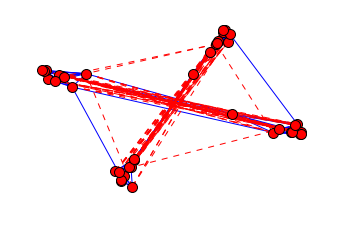

In [362]:
fig, ax = get_borderless_fig()
pos = signed_layout(g)
# draw_nodes(g, pos)
nx.draw_networkx_nodes(g, pos, node_size=100, ax=ax)
draw_edges(g, pos, ax=ax)

# demo on a toy graph

- two polarized communities, each has 20 nodes, which are divided into 2 opposing raphs
- random noise edges are added:
  - inside each community
  - between communities
- in total, 40 nodes
  - community 1: 0-19, where **0-9** are opposing **10-19**
  - community 2: 20-39, where **20-29** are opposing **30-39**

WARN: m less than n, problem likely degenerate
rank is 2
is rank one?  False
WARN: m less than n, problem likely degenerate
rank is 2
is rank one?  False


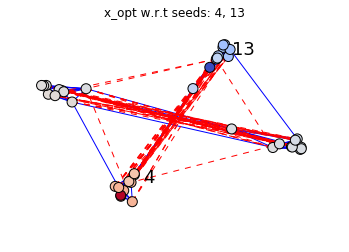

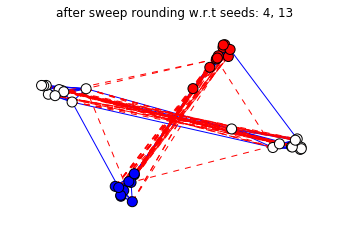

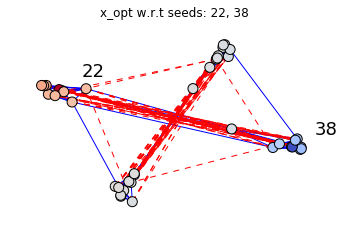

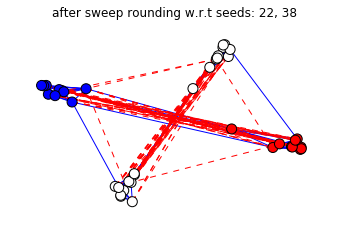

In [365]:
from matplotlib import pyplot as plt

kappa = 0.5

seeds_list = [
    [[4], [13]],
    [[22], [38]]
]

for seeds in seeds_list:
    x_opt, opt_val = query_graph_using_dense_matrix(g, seeds, kappa=kappa, verbose=1)

    fig, ax = get_borderless_fig()
    nx.draw_networkx_nodes(g, pos, node_size=100, node_color=x_opt, cmap=plt.cm.coolwarm, ax=ax)
    draw_edges(g, pos, ax=ax)
    ax.set_title('x_opt w.r.t seeds: {}'.format(', '.join(map(str, flatten(seeds)))))
    for v in flatten(seeds):
        ax.text(pos[v][0]+0.04, pos[v][1]+0.04, str(v), fontsize=18)
    
    c1, c2, C, beta = sweep_on_x(g, x_opt, verbose=0)
    
    colors = np.zeros(g.number_of_nodes())
    colors[c1] = 1
    colors[c2] = -1
    fig, ax = get_borderless_fig()
    nx.draw_networkx_nodes(g, pos, node_size=100, node_color=colors, cmap=plt.cm.bwr, ax=ax)
    draw_edges(g, pos, ax=ax)
    ax.set_title('after sweep rounding w.r.t seeds: {}'.format(', '.join(map(str, flatten(seeds)))))
    

# effect of $\kappa$

test graph: 4 pairs of polarized communities

In [369]:
import random

random.seed(12345)
np.random.seed(12345)

size = 10
k = 4
g, true_comms, true_groupings = make_polarized_graphs(k, [(size, size) for i in range(k)])
A = nx.adj_matrix(g, weight='sign')

#communities 4
comm#1 sizes: 10 10
comm#2 sizes: 10 10
comm#3 sizes: 10 10
comm#4 sizes: 10 10


In [376]:
# using two seed nodes
n_reps = 1
target_comm = np.random.choice(len(true_comms))        
v1 = np.random.choice(true_groupings[target_comm][0])
v2 = np.random.choice(true_groupings[target_comm][1])

# bad example: 
target_comm, v1, v2 = 2, 43, 56
# good example:
# target_comm, v1, v2 = 3, 68, 77
seeds = [[v1], [v2]]


perf = []
for kappa in np.linspace(0, 1.0, 11):
    for i in range(n_reps):            
        res = run_pipeline(g, seeds, kappa, target_comm, true_comms, true_groupings)
        res['kappa'] = kappa
        perf.append(res)
    


WARN: m less than n, problem likely degenerate
beta= 0.060498220640569395
upperbound sqrt(opt_val)= 0.41284385088416714
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.0659536541889483
upperbound sqrt(opt_val)= 0.4569171721234783
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.0659536541889483
upperbound sqrt(opt_val)= 0.5138684892369679
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.0659536541889483
upperbound sqrt(opt_val)= 0.5788949750631615
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.08592321755027423
upperbound sqrt(opt_val)= 0.6566950962766597
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.09285714285714286
upperbound sqrt(opt_val)= 0.7433998354816646
does upperbound hold? True
----------
WARN: m less than n, problem likely degenerate
beta= 0.0928571428

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


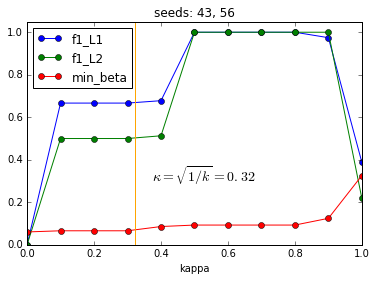

In [377]:
df = pd.DataFrame.from_records(perf)

agg_df = df[['kappa', 'f1_L1', 'f1_L2', 'min_beta']].groupby('kappa').mean()
agg_df.reset_index(level=0, inplace=True)

fig, ax = plt.subplots(1, 1)

seeds_str = ', '.join(map(str, flatten(seeds)))
agg_df.plot(
    x='kappa',
    y=['f1_L1', 'f1_L2', 'min_beta'],
    ylim=[0, 1.05],
    style='-o',
    title='seeds: {}'.format(seeds_str),
    ax=ax
)

theoretical_kappa = get_theoretical_kappa(
    true_comms[target_comm], 
    flatten(seeds),
    A
)

ax.axvline(x=theoretical_kappa, color='orange')
ax.text(
    theoretical_kappa+0.05,
    0.3,
    '$\kappa = \sqrt{{1 / k}}={:.2f}$'.format(theoretical_kappa),
    fontsize=14
)

fig.savefig('figs/effect-of-kappa/seeds-{}.png'.format(seeds_str))

# why the bad example (seed 43 and 56)

WARN: m less than n, problem likely degenerate
best_t 2.8098051023366772e-06
sbr of the ground truth 0.09285714285714286


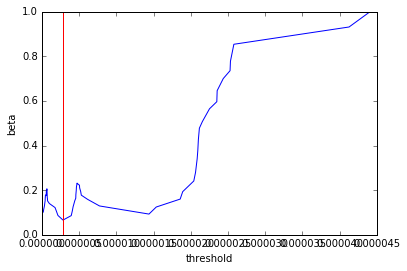

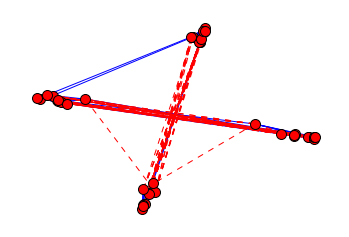

In [258]:
seeds = [[43], [56]]
kappa = 0.3
x_opt, _ = query_graph(g, seeds, kappa=kappa, verbose=0)
ts = sorted(np.abs(x_opt))[2:]  # avoid very small threshold
sbr_list = [sbr_by_threshold(g, x_opt, t) for t in ts]

fig, ax = plt.subplots(1, 1)
ax.plot(ts, sbr_list)

best_t = ts[np.argmin(sbr_list)]
ax.axvline(best_t, color='red')
ax.set_xlabel('threshold')
ax.set_ylabel('beta')
fig.savefig('figs/dataset-issue-on-toy-graph/sweeping_plot.png')

best_sbr = np.min(sbr_list)
print('best_t', best_t)
C = (np.abs(x_opt) >= best_t).nonzero()[0]
print('sbr of the ground truth', sbr(A, *true_groupings[2]))

S1, S2, S, opt_beta = sweep_on_x(g, x_opt)
subg = g.subgraph(S)

fig, ax = get_borderless_fig()
subg = nx.convert_node_labels_to_integers(subg)
new_pos = signed_layout(subg)
nx.draw_networkx_nodes(subg, new_pos, node_size=100)
# draw_nodes(subg, new_pos, ax=ax)
draw_edges(subg, new_pos, ax=ax)
fig.savefig('figs/dataset-issue-on-toy-graph/detected_subgraph.png')